# Time Series Air Quality Prediction with Neural Networks


\
How to use this notebook:

> This notebook contains the coding part and the notes part. It also quotes and references articles that I found useful so I added them in as well.

> End of this notebook is a Ready-To-Go for simulation.




In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.impute import KNNImputer
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Dataset

This project used a dataset named `Air Quality` available on the UCI Machine Learning Repository. The dataset was tailored for this
project and made some modifications. **Therefore, please only use the `AirQualityUCI_Modified.xlsx` dataset from this repository.**

In [81]:
file_path = './AirQualityUCI_Modified.xlsx'
data = pd.read_excel(file_path)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.600,48.875001,0.757754
1,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.300,47.700000,0.725487
2,2004-03-10,20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.900,53.975000,0.750239
3,2004-03-10,21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.000,60.000000,0.786713
4,2004-03-10,22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.150,59.575001,0.788794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8353,2005-04-01,10:00:00,1.0,947.75,-200,3.525377,683.75,180.0,851.00,119.9,1010.50,599.00,16.450,40.775000,0.757020
8354,2005-04-01,11:00:00,1.0,938.50,-200,3.576895,686.75,197.1,869.75,122.9,980.50,549.50,18.925,33.775001,0.731210
8355,2005-04-01,12:00:00,1.1,924.50,-200,4.045717,713.25,172.0,853.00,114.9,956.75,518.00,19.175,29.475000,0.648005
8356,2005-04-01,13:00:00,1.3,923.75,-200,4.519882,738.75,183.6,833.75,122.2,966.00,540.50,19.925,26.300000,0.605405


The given dataset contains 8,358 instances of hourly averaged responses from an array of five metal oxide chemical sensors embedded in an air quality chemical multisensor device. The device was located in the field in a significantly polluted area at road level within an Italian city. Data were recorded from March 2004 to February 2005 (one year), representing the longest freely available recordings of on-field deployed air quality chemical sensor device responses. Ground truth hourly averaged concentrations for carbon monoxide, non-methane hydrocarbons, benzene, total nitrogen oxides, and nitrogen dioxide among other variables were provided by a co-located reference-certified analyser. Missing values within the dataset are tagged with `-200` value.

# **Data Preprocessing**

**a. Identify variation range**


*   Analyze the range and distribution of each variable in the dataset to understand their behavior



In [82]:
data.describe()

,Date,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,8358,8358.000000,8358.000000,8358.000000,8358.000000,8358.000000,8358.000000,8358.000000,8358.000000,8358.000000,8358.000000,8358.000000,8358.000000,8358.000000
mean,2004-09-20 04:16:42.727925376,-36.187928,1038.533411,-158.119167,0.894268,889.323901,162.607933,790.043631,53.912228,1382.696877,968.419987,8.713360,38.201273,-7.780588
min,2004-03-10 00:00:00,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,2004-06-17 00:00:00,0.500000,915.062500,-200.000000,3.968875,709.000000,45.000000,634.250000,49.000000,1177.500000,692.062500,10.450000,33.974999,0.675253
50%,2004-09-21 00:00:00,1.500000,1048.500000,-200.000000,7.826424,892.000000,136.000000,793.000000,95.000000,1442.500000,940.125000,17.225000,48.137500,0.971383
75%,2004-12-27 00:00:00,2.600000,1215.687500,-200.000000,13.636091,1104.750000,282.000000,958.687500,132.000000,1658.187500,1251.750000,24.075000,61.593750,1.307486
max,2005-04-01 00:00:00,11.900000,2007.750000,1189.000000,63.741476,2214.000000,1479.000000,2682.750000,339.700000,2775.000000,2522.750000,44.600000,87.174999,2.231036
std,NaN,79.260156,338.349674,141.931963,43.609487,350.473599,260.322621,327.590979,130.150259,479.299713,464.837162,45.516939,53.678637,41.139234


As we can see in the above table, the range of each variable are indicated by [min, max] on each column. Min of each column shows -200 and some mean values are negative values.

In addition, just in case, check for any null values in the table.

In [83]:
print("Column Name      No. of NULL Values")
print('===================================')
null_data = data.isnull().sum()
null_data

Column Name      No. of NULL Values


Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64

There following code plots the distribution of each variable.

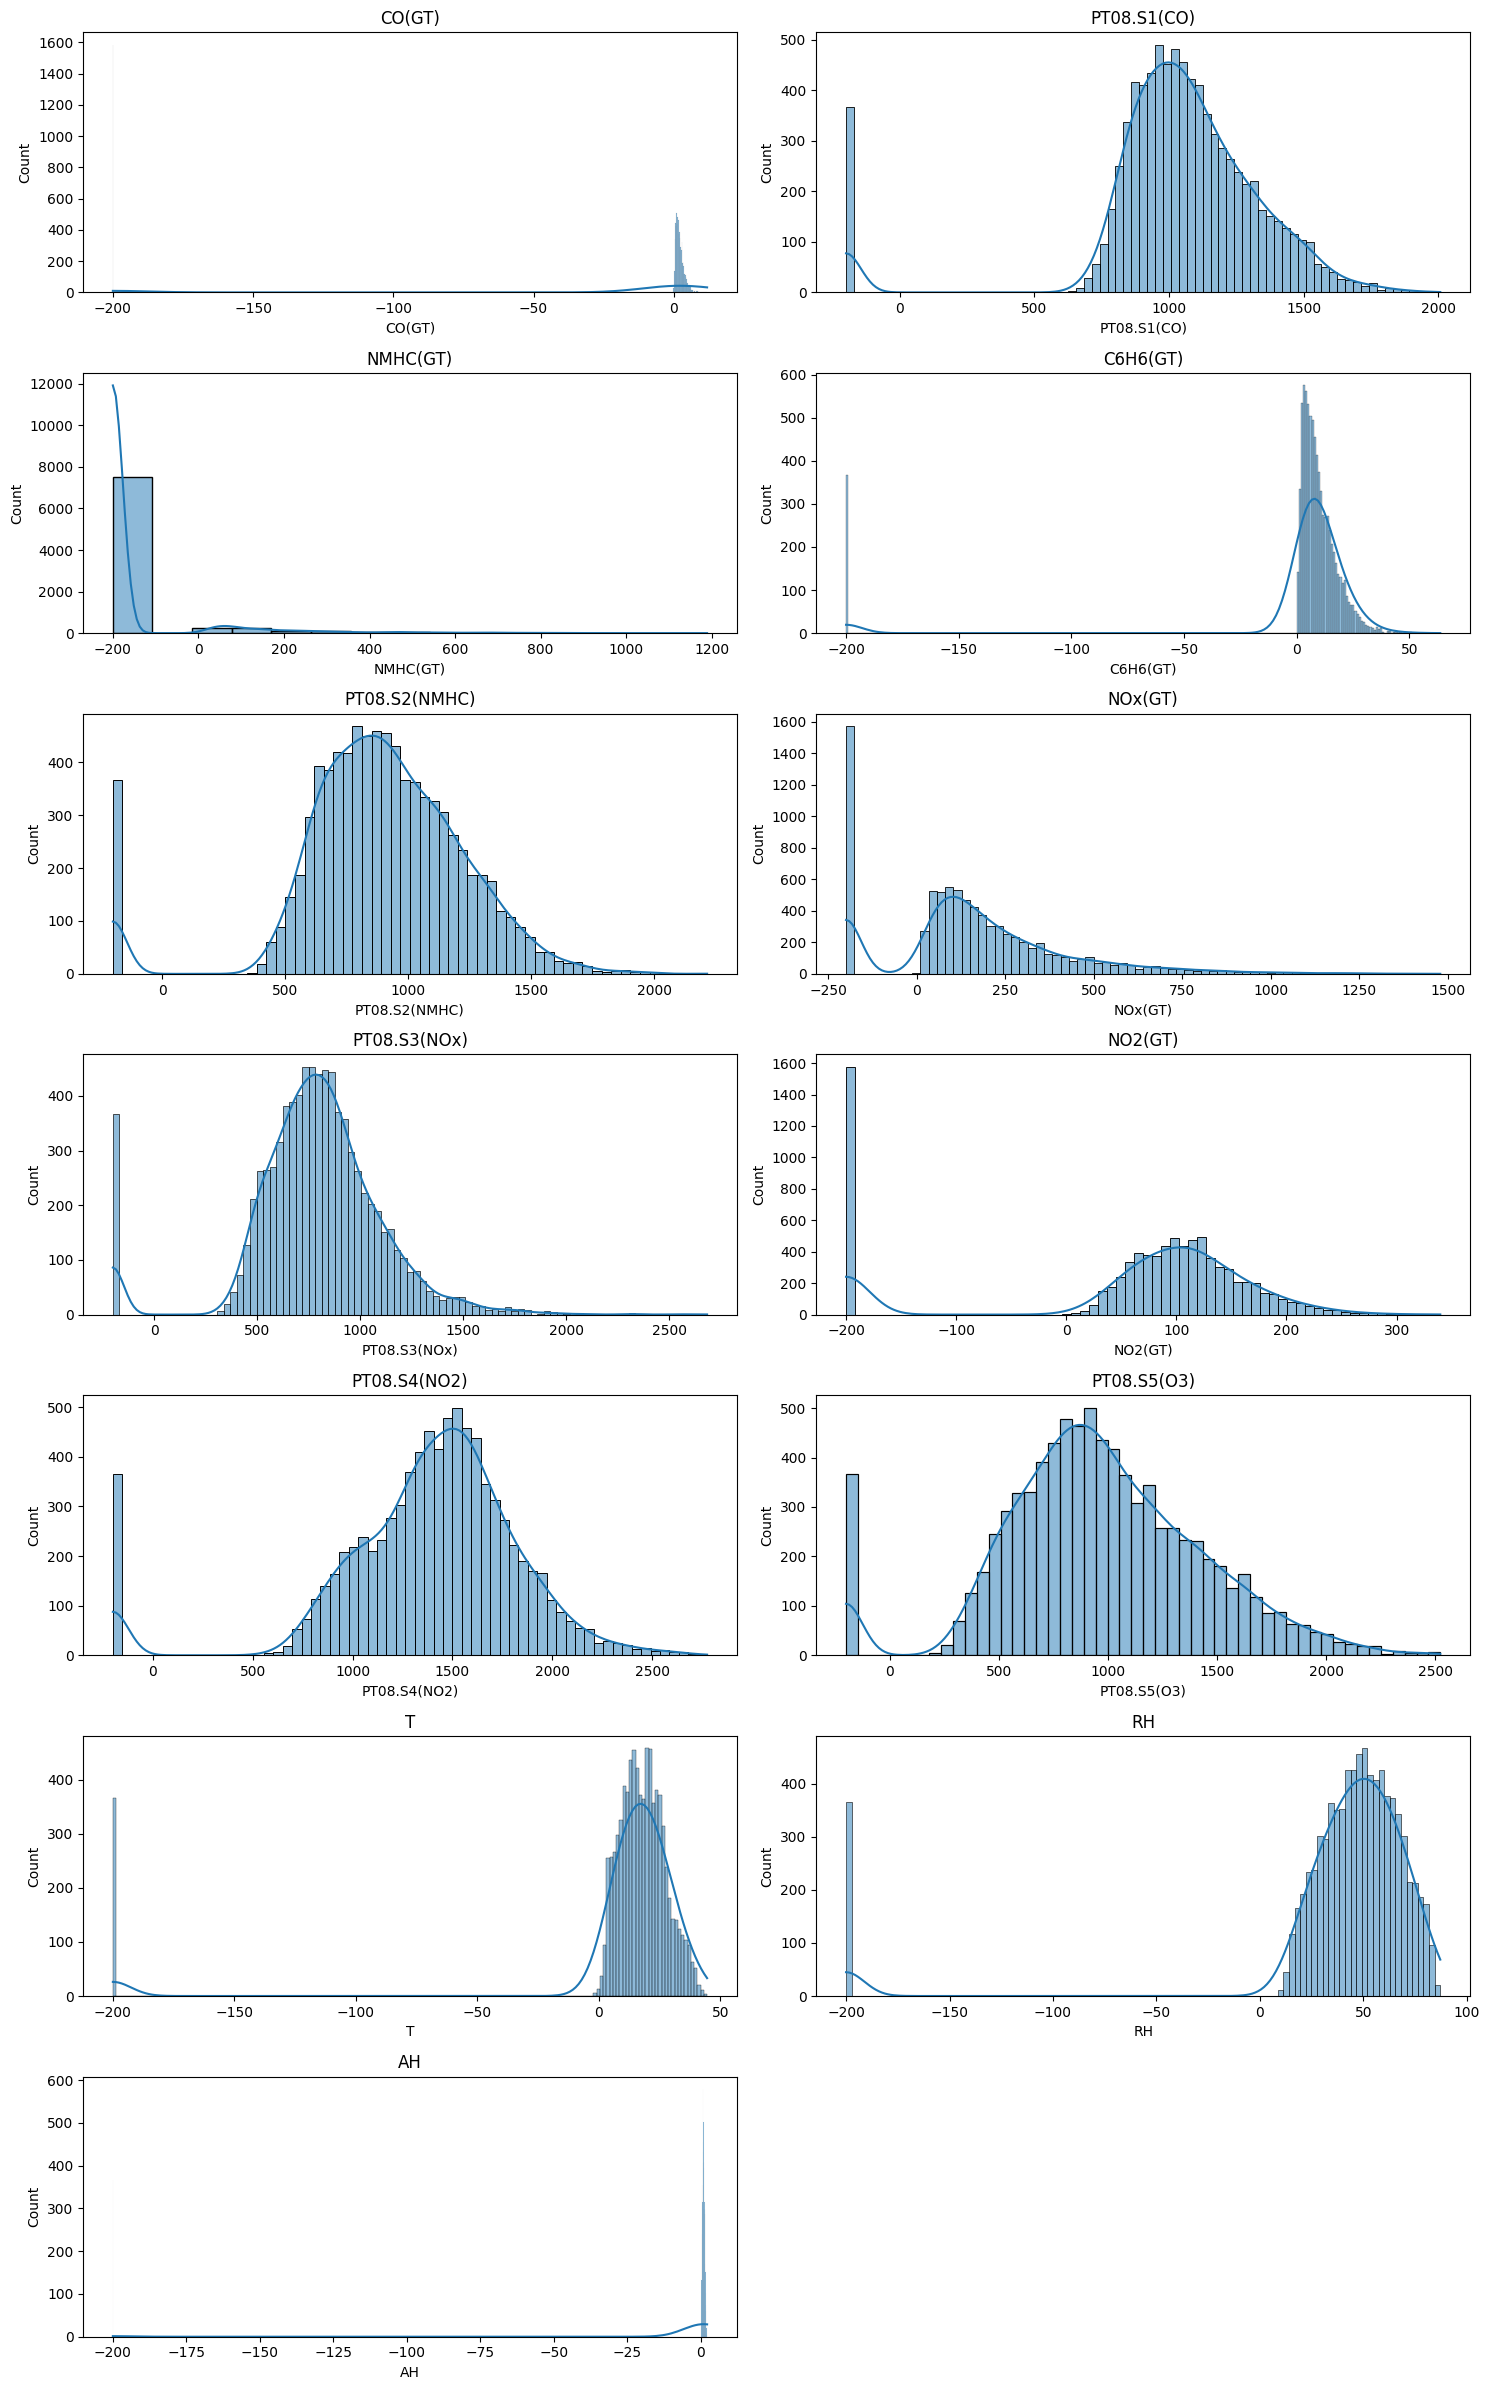

In [84]:
variables = data.columns[2:]
plt.figure(figsize=(15, 24))
for i, var in enumerate(variables, 1):
    plt.subplot(7,2,i)
    sns.histplot(data[var], kde=True)
    plt.title(var)
    plt.tight_layout()
plt.show()

As we can see above, some columns contains lots of -200 values which may contribute to negative mean values.

\
**b. Plot each vairable**


*   Plot time series graphs for each variable to observe trends and outliers



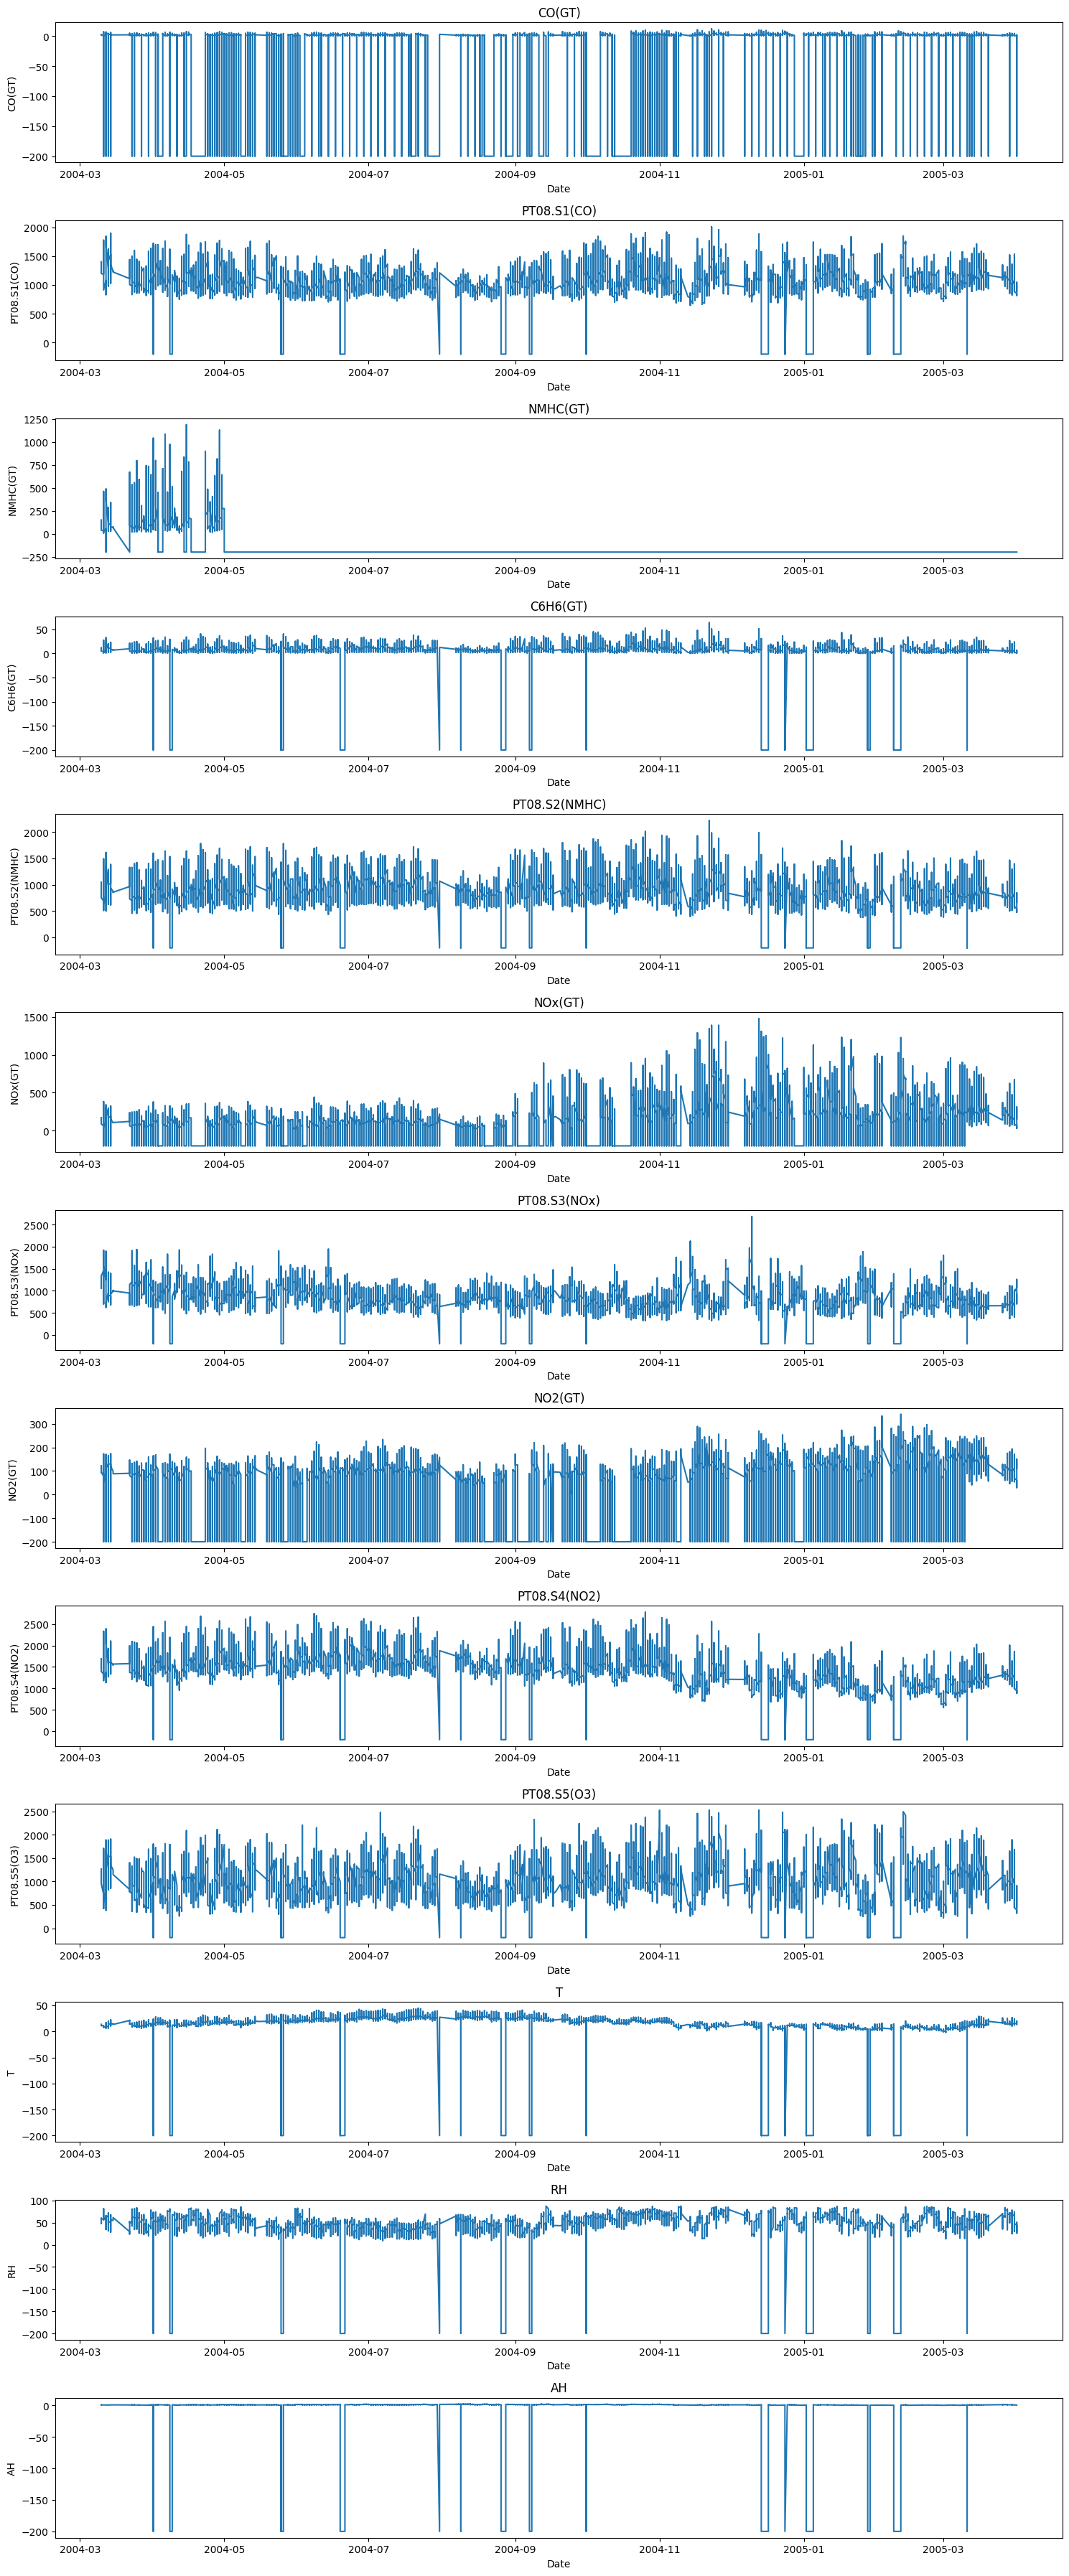

In [85]:
# Create a copy and Set the date column as the index
data1 = data.copy()
data1.set_index('Date', inplace=True)

plt.figure(figsize=(15, 36))
variables1 = data1.columns[1:]
for i, var in enumerate(variables1):
    plt.subplot(len(variables1), 1, i+1)
    plt.plot(data1.index, data[var])
    plt.xlabel('Date')
    plt.ylabel(var)
    plt.title(var)
    plt.tight_layout()

plt.show()

The above plots show the time series for each variable and the trend. As we can see, there are lots of missing values in the dataset, namely -200. Thus, we need to handle these missing data.

The following code shows the number of missing values in each columns.

In [86]:
print("Column Name      No. of Missing Values")
print('======================================')
missing = data[data.columns] == -200
missing.sum()

Column Name      No. of Missing Values


Date                0
Time                0
CO(GT)           1585
PT08.S1(CO)       366
NMHC(GT)         7525
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1573
PT08.S3(NOx)      366
NO2(GT)          1576
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
dtype: int64

# **Handle Missing Data**

Since we know that the missing values are represented by -200, if we simply compute the training, it can decrease the accuracy and bias the model. Thus, we need to address this issue appropriately.

According to [Geeksforgeeks](https://www.geeksforgeeks.org/ml-handling-missing-values/) and [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2021/10/handling-missing-value/), there are several common strategies for handling them.



*   Deletion - this involves removing rows or columns with missing values. Since our dataset is relatively not large and deleting rows with missing values can significantly decrease number of samples in the dataset (eg. column NMHC(GT) has over 75% missing values according to the above plot). Thus, the dataset might become too small after deleting all rows with missing value hence will be problematic for the training and testing process.

*   Imputation - this is a technique that involes replaceing missing values with estimates. Commonly used techniques for time series data are Forward Fill and Backwrad Fill, Linear Interpolation, Time-Based Interpolation, Moving Average, kNN, etc.


\
The following code replaces missing value -200 with null value. Hence, change in range and distribution of each variable in the dataset.



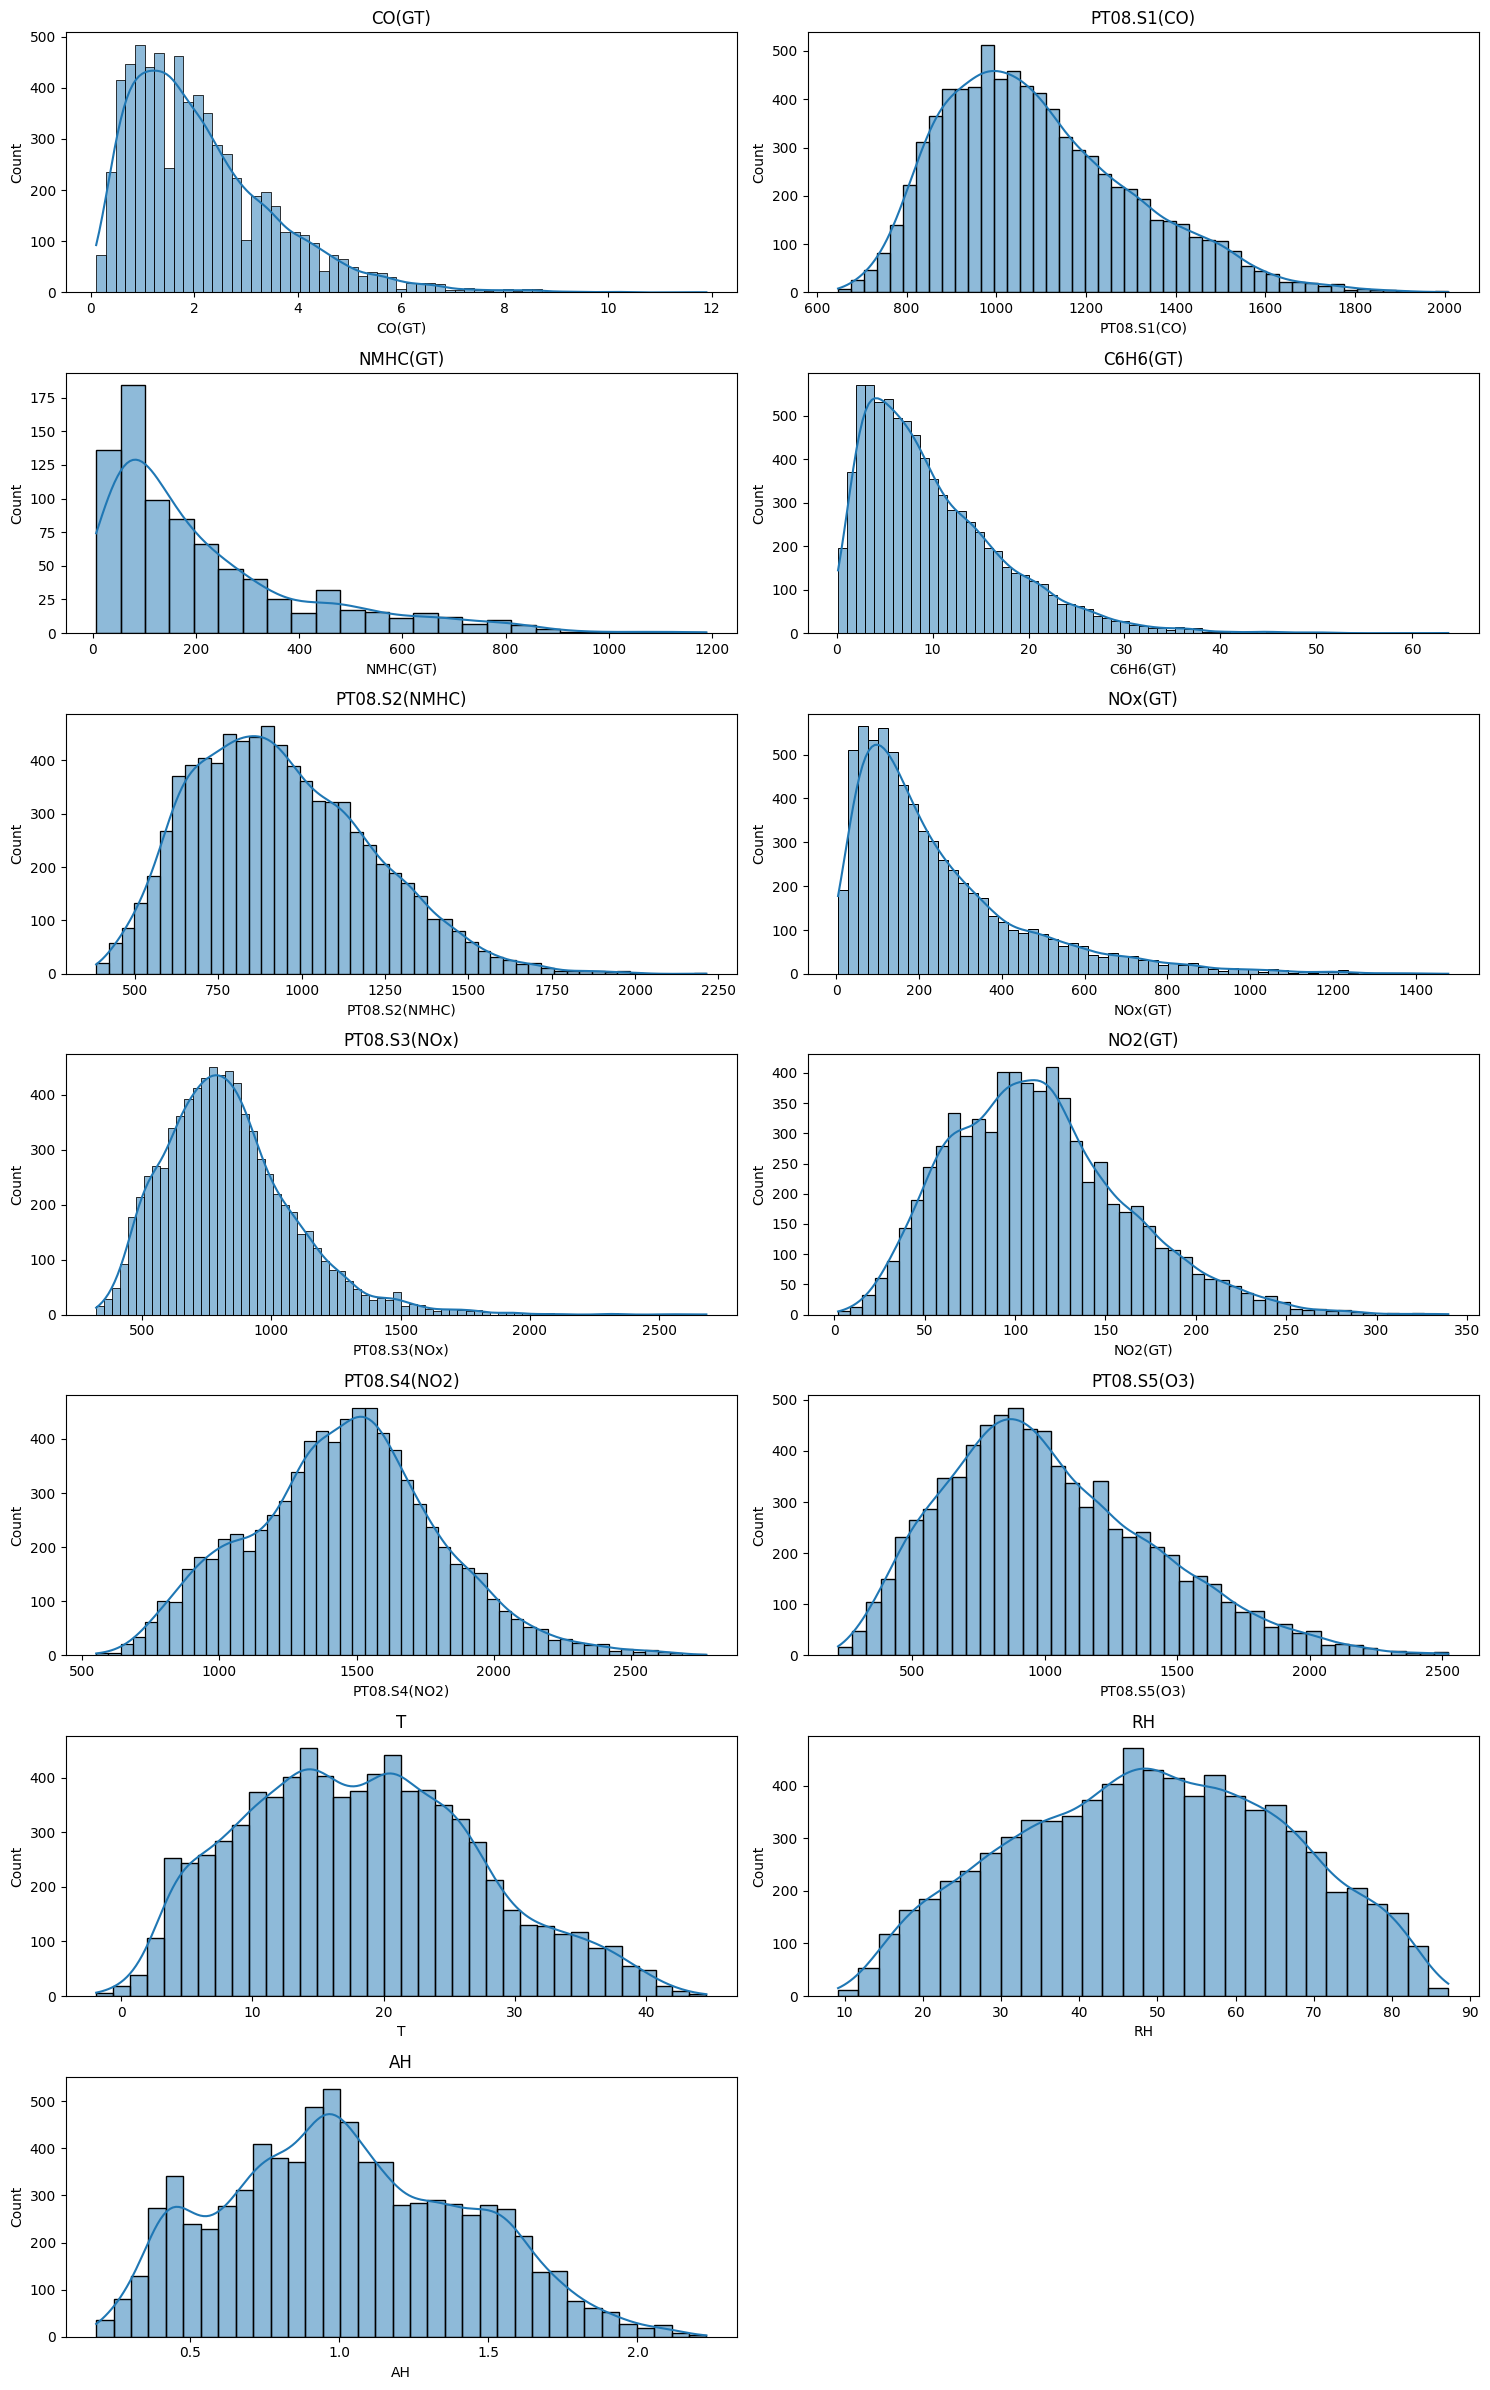

,Date,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,8358,6773.000000,7992.000000,833.000000,7992.000000,7992.000000,6785.000000,7992.000000,6782.000000,7992.000000,7992.000000,7992.000000,7992.000000,7992.000000
mean,2004-09-20 04:16:42.727925376,2.146951,1095.253034,220.216086,10.094381,939.210356,246.673117,835.383467,112.916308,1455.177740,1021.928710,18.271555,49.109890,1.022252
min,2004-03-10 00:00:00,0.100000,647.250000,7.000000,0.149048,383.250000,4.000000,322.000000,2.000000,551.000000,221.000000,-1.900000,9.175000,0.184679
25%,2004-06-17 00:00:00,1.100000,933.187500,67.000000,4.448750,735.000000,96.000000,657.500000,77.000000,1223.687500,727.937500,11.400000,35.950000,0.724195
50%,2004-09-21 00:00:00,1.800000,1059.625000,147.000000,8.224492,908.375000,179.000000,804.750000,109.000000,1462.625000,963.250000,17.849999,49.325000,0.992256
75%,2004-12-27 00:00:00,2.900000,1225.562500,297.000000,14.019301,1117.250000,327.000000,968.750000,142.000000,1671.500000,1273.062500,24.450000,62.224999,1.322506
max,2005-04-01 00:00:00,11.900000,2007.750000,1189.000000,63.741476,2214.000000,1479.000000,2682.750000,339.700000,2775.000000,2522.750000,44.600000,87.174999,2.231036
std,NaN,1.450495,215.054472,207.771593,7.467145,267.617913,214.303404,255.501640,49.090849,346.794455,400.721923,8.952090,17.192556,0.405450


In [87]:
# Replace -200 with NaN
data.replace(-200, np.nan, inplace=True)

plt.figure(figsize=(15, 24))
variables = data.columns[2:]
for i, var in enumerate(variables, 1):
    plt.subplot(7,2,i)
    sns.histplot(data[var], kde=True)
    plt.title(var)
    plt.tight_layout()
plt.show()

data.describe()

# Choose of Imputation Method

1.   **Forrward Fill and Backward Fill** - this method propagates the last observed value forward/backward until a new value is encountered.

2.   **Linear Interpolation** - this method estimates the missing values by interpolating linearly (plotting a stright line) between the known values. It works well when data points are evenly spaced and there is a relatively constant rate of change between them.

3.   **Time-Based Interpolation** - interpolates missing values based on the time index, which can be more appropriate for time series data. This method is particularly useful for time series data where data points are not evenly spaced in time.

4. **Polynomial Interpolation** - involves fitting a polynomial function to a set of known data points and using this function to estimate the missing values. This is useful when the relationship between data points is nonlinear.

5. **kNN** - according to [Brownlee](https://machinelearningmastery.com/knn-imputation-for-missing-values-in-machine-learning/) KNN imputation often involves selecting the distance measure (e.g. Euclidean) and the number of contributing neighbors for each prediction, the k hyperparameter of the KNN algorithm.

We also should take time and date sequence in consideration. Since we have an evenly spaced out in time dataset, it seems to be approapriate to consider linear or polynomial interpolation. Polynomial Interpolation is useful for capturing nonlinear relationship in the data, however, the downside could be running the risk of overfitting. Upon these comparison, linear interpolation seems more suitable for this dataset.

However, since some column such as NMHC(GT) contains lots of missing value from one point to the end, using linear interpolation meaning that most of the missing values in this column would be filled with garbage value which would make this column unusable. On the other hand, if using kNN imputation, this column can perhaps filled with some meaningful values that suggests its identity through its neigbours.

\
The following code plots time series graphs for each variable after kNN interpolation. But first, we need to normalize the dataset priot to imputation kNN since kNN is based on distances. Features with larger scales can dominate the gradient updates, leading to inefficient training, especially those based on gradient descent (such as neuro network).

Normalization ensures that all features contribute equally to the model, preventing features with larger magnitudes from disproportionately affecting the model’s predictions.

The following code also normalize x using Min-Max Normalizer. Min-Max Scaling is a process of converting the given data into its corresponding value in a fixed range [0,1].

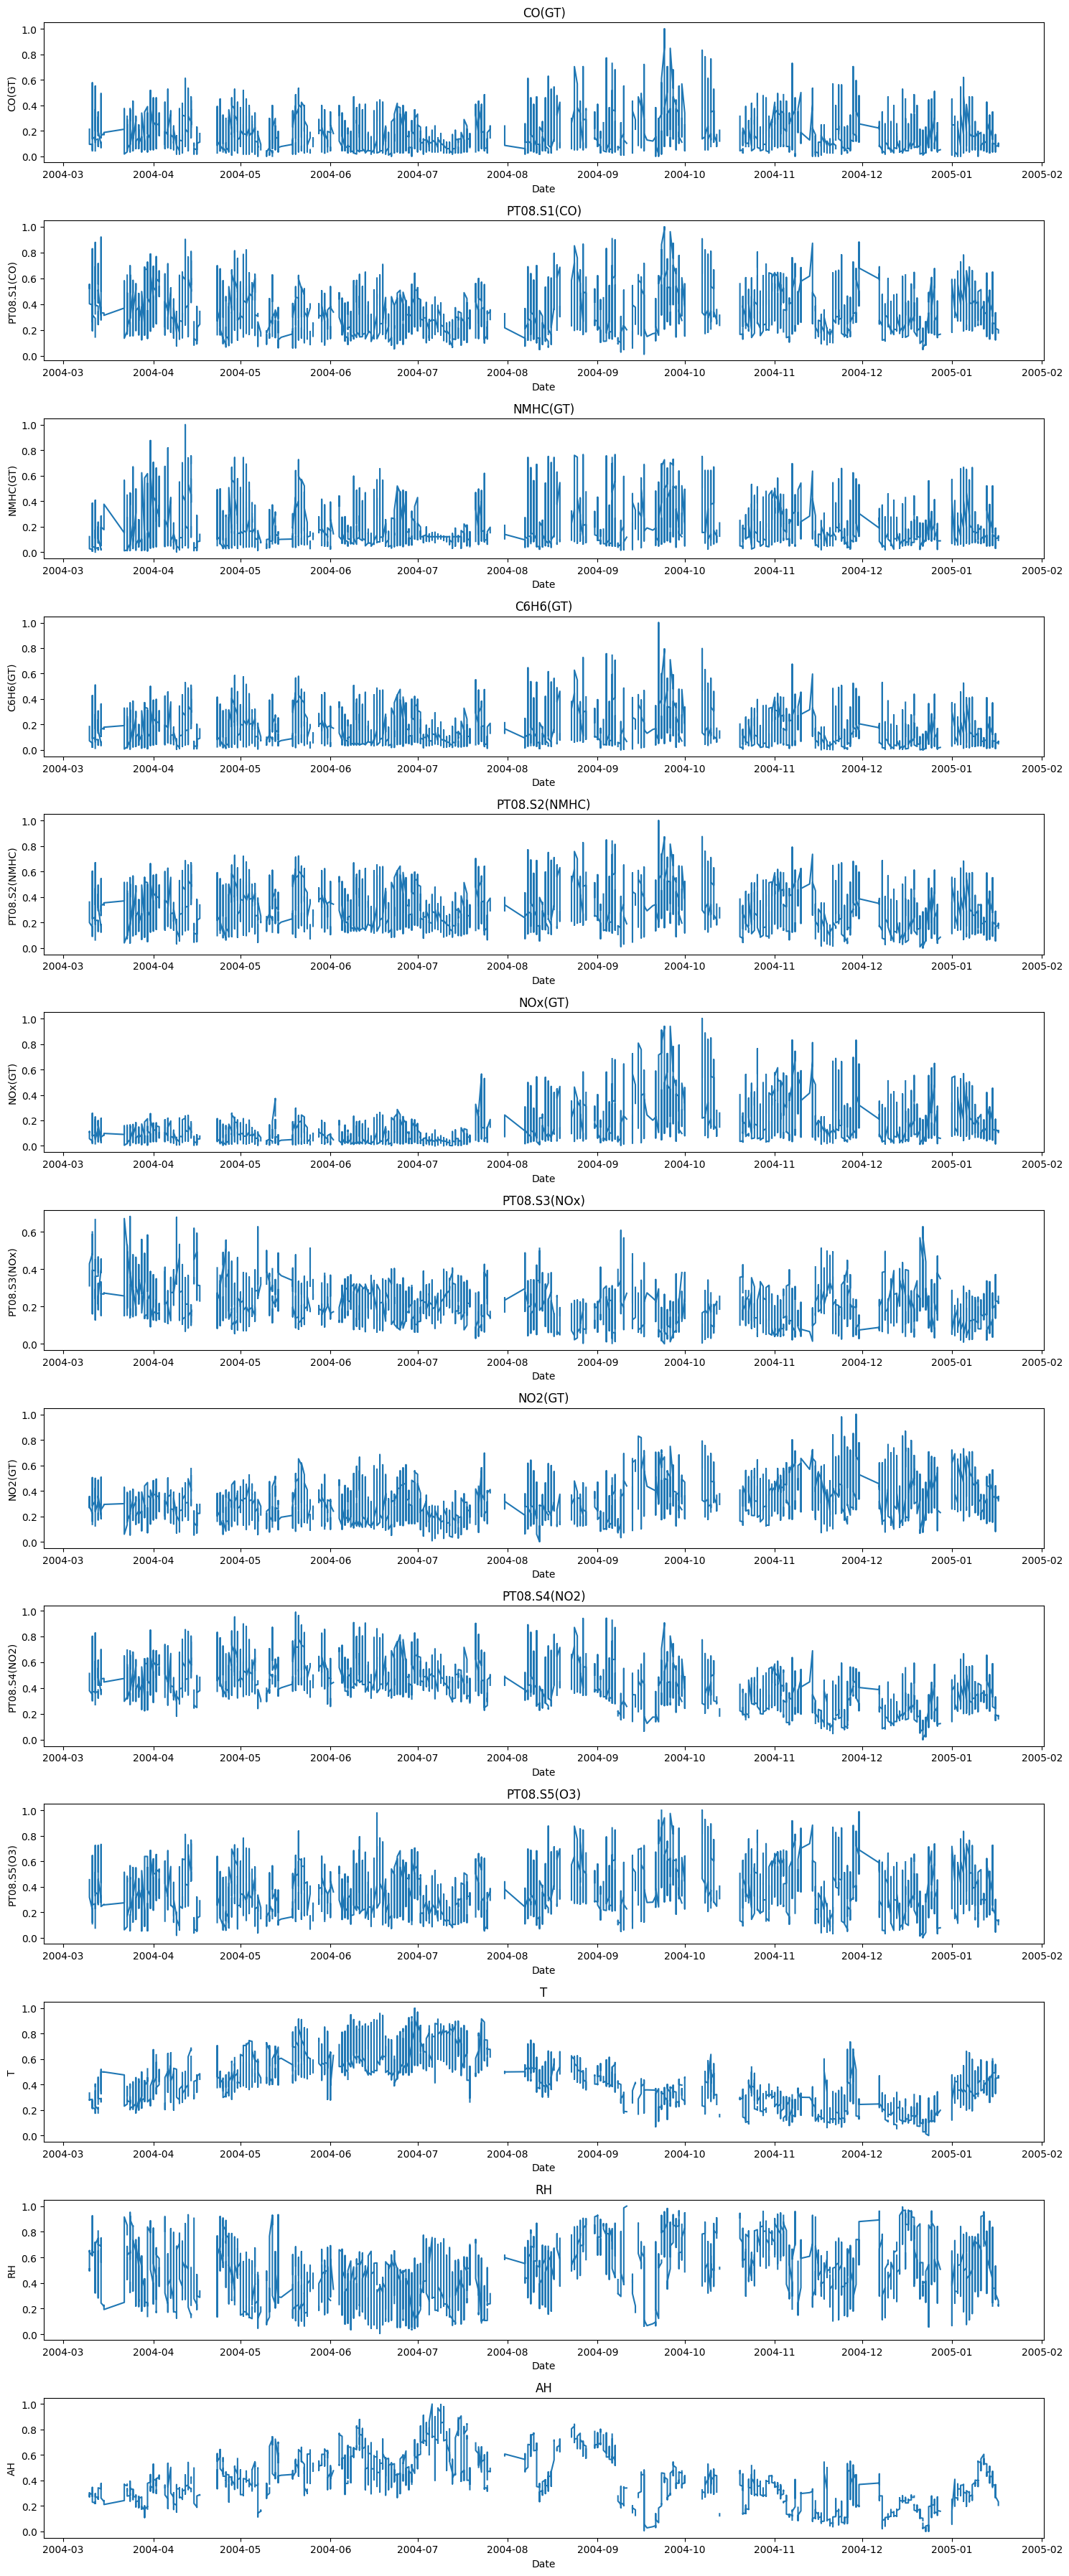

In [88]:
data = pd.read_excel(file_path)
data.replace(-200, np.nan, inplace=True)
data = data.dropna(subset=['CO(GT)'])

scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data.iloc[:, 2:])

knn_imputer = KNNImputer(n_neighbors=10)
# Perform KNN imputation on numerical data, excluding the 'Date' and 'Time' columns
data_knn = pd.DataFrame(knn_imputer.fit_transform(data_normalized), columns=data.columns[2:])

# Set 'Date' as index (assuming 'Date' is the first column)
data_knn['Date'] = data['Date']  # Add 'Date' column back
data_knn.set_index('Date', inplace=True)

variables = data_knn.columns[:]

# Creating the plot
plt.figure(figsize=(15, 36))
for i, var in enumerate(variables):
    plt.subplot(len(variables), 1, i + 1)
    plt.plot(data_knn.index, data_knn[var])
    plt.xlabel('Date')
    plt.ylabel(var)
    plt.title(var)
    plt.tight_layout()
plt.show()

In [89]:
data_knn.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,6773.000000,6773.000000,6773.000000,6773.000000,6773.000000,6773.000000,6773.000000,6773.000000,6773.000000,6773.000000,6773.000000,6773.000000,6773.000000
mean,0.173470,0.338112,0.185955,0.160496,0.308470,0.164611,0.211910,0.328561,0.402137,0.359642,0.423164,0.509952,0.402683
std,0.122923,0.158103,0.138695,0.117374,0.145351,0.145872,0.106877,0.144438,0.155448,0.177120,0.191003,0.217885,0.199449
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.084746,0.220507,0.097716,0.070759,0.196470,0.061711,0.137986,0.219189,0.295863,0.231889,0.277419,0.344994,0.258036
50%,0.144068,0.313671,0.145685,0.132670,0.293747,0.118126,0.198719,0.313888,0.403103,0.335723,0.411290,0.513479,0.388222
75%,0.237288,0.434399,0.226396,0.223034,0.405391,0.220638,0.266017,0.414391,0.502136,0.471706,0.552151,0.672336,0.536776
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In order to visualise the distribution. The following code plots the box plot of each columns.


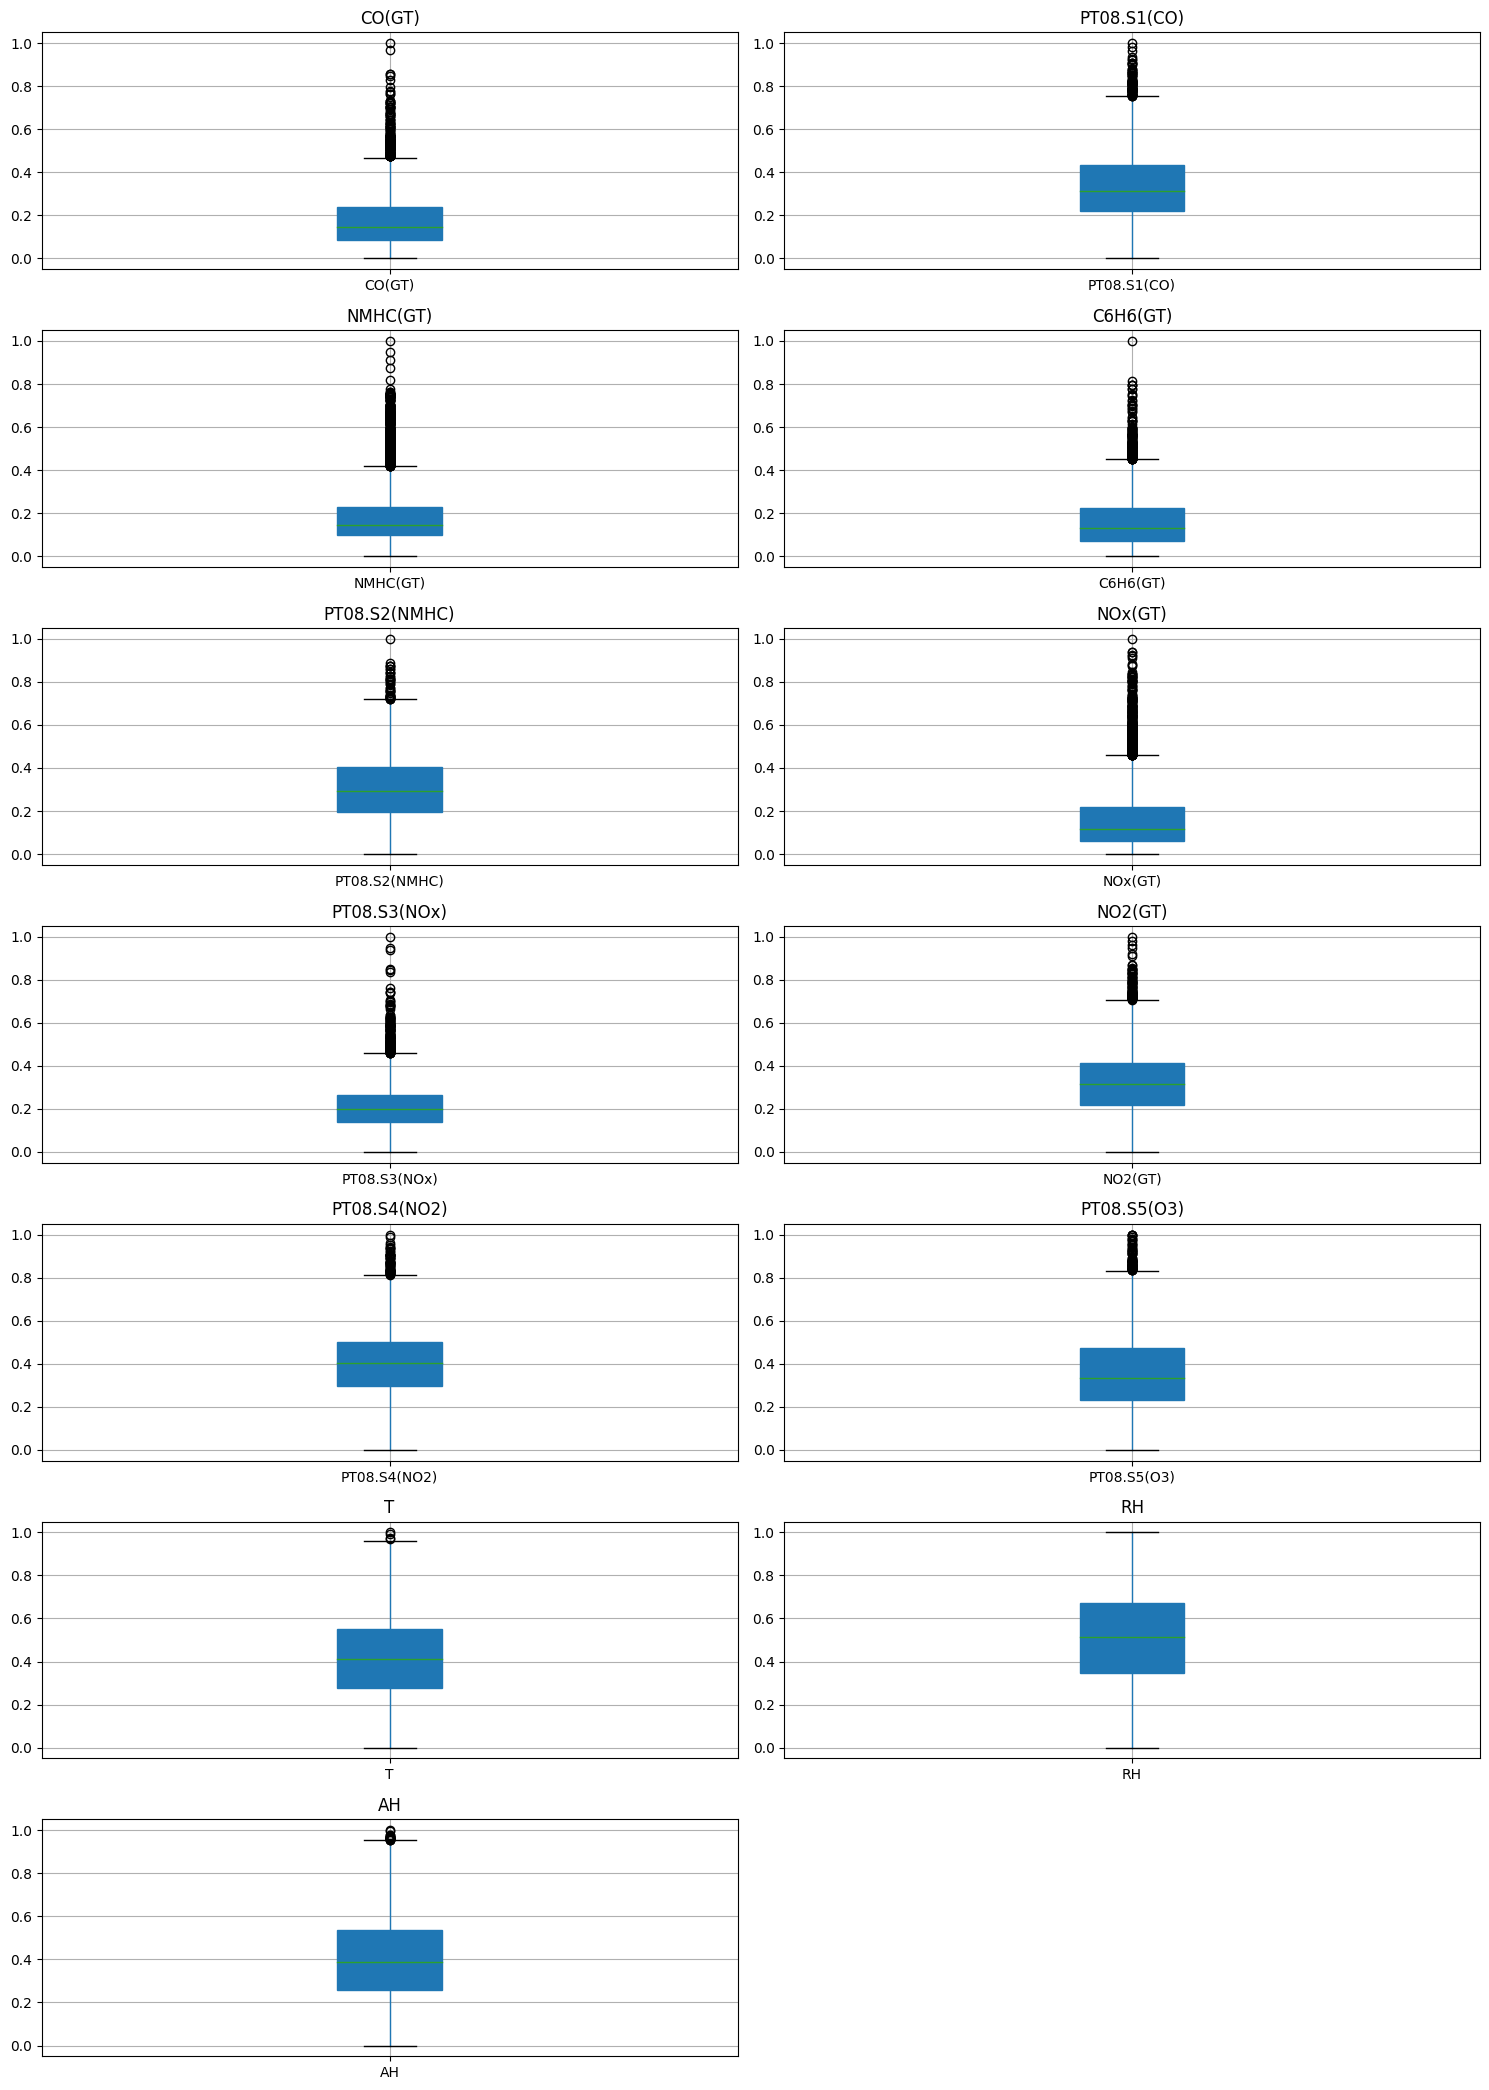

In [90]:
data_subset = data_knn.iloc[:, :]

num_columns = 2
num_rows = (data_subset.shape[1] + 1) // num_columns

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 3 * num_rows))
axes = axes.flatten()

# Plot each column in a separate subplot
for i, col in enumerate(data_subset.columns[0:]):
    data_subset.boxplot(column=col, ax=axes[i], patch_artist=True,)
    axes[i].set_title(col)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

It needs to be caution that these filled data are only estimations and should only be used for training which is why I didn't interpolate the target column. In addition, I don't think we should impute target variable (unless we sure about the value from prior knowdege). Since I am not confident to make any assumption about the target value, it may not be wise to impute. Also since our sample size is  large enough for training and testing, reletively speaking.

\
# **Classification Model**

According to [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/), finding the best set of features allow models optimization. The article also illustrated a few usful techniques.

In [91]:
# In order to do feature selection, we need to find Y
threshold = data_knn['CO(GT)'].mean()
data_knn['CO(GT)_threshold'] = (data_knn['CO(GT)'] > threshold).astype(int)
data_knn.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,CO(GT)_threshold
Date,,,,,,,,,,,,,,
2004-03-10,0.211864,0.523888,0.120981,0.184294,0.360514,0.108622,0.311024,0.328694,0.513040,0.454654,0.333333,0.509628,0.287117,1
2004-03-10,0.161017,0.474090,0.088832,0.145214,0.310850,0.065852,0.360796,0.266509,0.453125,0.326382,0.326882,0.494544,0.270951,0
2004-03-10,0.177966,0.554759,0.068528,0.138933,0.302367,0.084861,0.346500,0.331655,0.451214,0.370588,0.296774,0.575096,0.283352,1
2004-03-10,0.177966,0.535281,0.061760,0.142566,0.307292,0.112695,0.326168,0.355345,0.464366,0.426741,0.277419,0.652439,0.301626,1
2004-03-10,0.127119,0.459390,0.037225,0.099931,0.245588,0.084861,0.374034,0.337578,0.422212,0.386228,0.280645,0.646983,0.302669,0


The article from Analytics Vidhya introduced information gain. It measures the reduction in entropy or uncertainty about the target variable given a feature. In other words, it evaluates the information gain which are likely to be the most important for classification task.

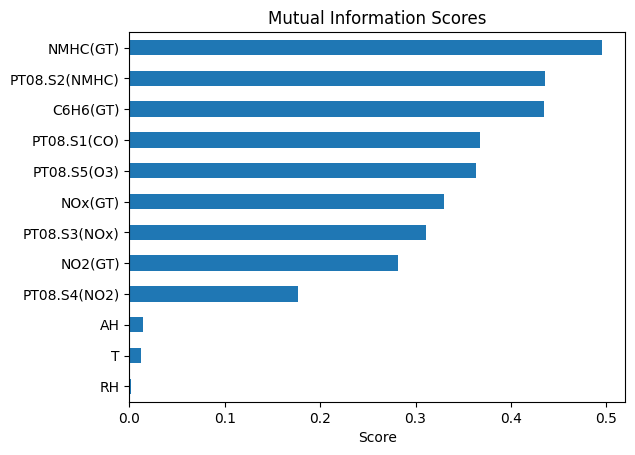

In [92]:
X = data_knn.drop(columns=['CO(GT)', 'CO(GT)_threshold'])
y = data_knn['CO(GT)_threshold']

mutual_info = mutual_info_classif(X, y)

# Create a DataFrame to display the results
mi_df = pd.DataFrame(mutual_info, index=X.columns, columns=['Mutual Information']).sort_values(by='Mutual Information')

mi_df.plot(kind='barh', legend=False)
plt.title('Mutual Information Scores')
plt.xlabel('Score')
plt.show()

Correlation Coefficient or Correlation Matrix is a common technique to measure the linear relationship between 2 or more variables. If two features are correlated, we can predict one from the other.

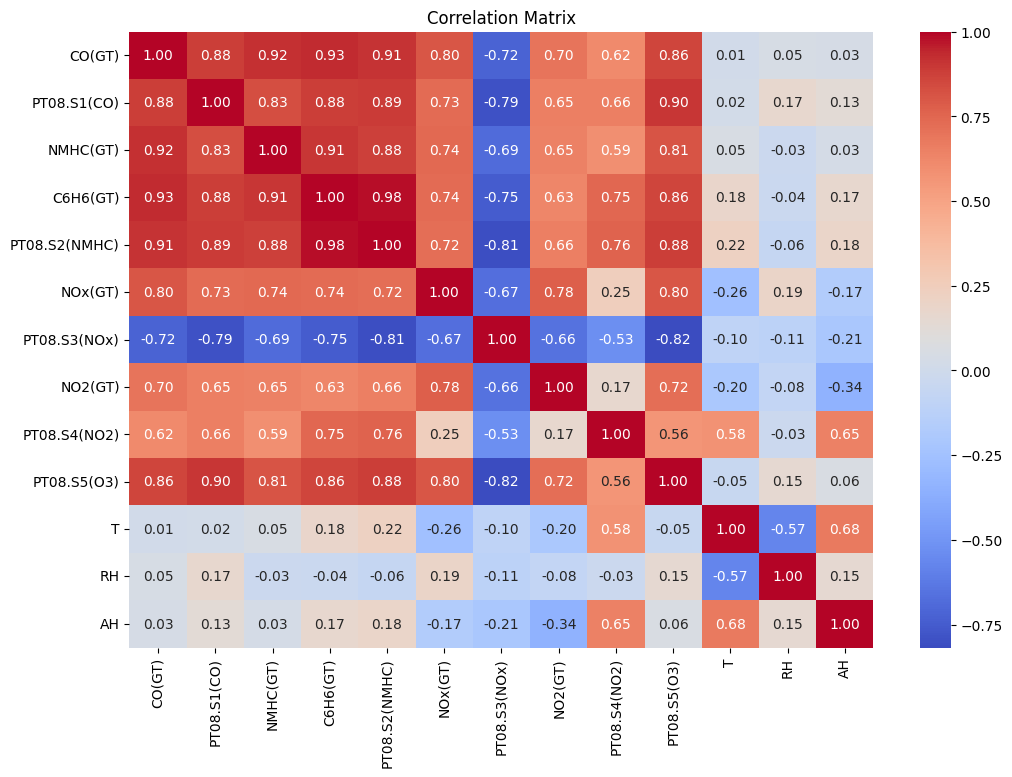

In [93]:
plt.figure(figsize=(12, 8))
corr_matrix = data_knn[data_knn.columns[0:-1]].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

From the Information Gain and Correlation Matrix plots above, we can see that some features are more correlate and share similar information pattern than others.

Upon the consideration of Box Plot, Mutual Information Score and Correlation Maxtrix, we can conclude that some features are less important and can be dropped, namely T, RH, and AH. PT08.S4(NO2) indicates a moderate positive linear relationship, suggests that the feature could be useful, but it is not strongly predictive on its own. Mutual information captures any kind of dependency (linear or non-linear), so even a low score might indicate some predictive power that is not captured by correlation. Therefore, it should be kept for training purpose.

\
Once we have decided which columns are useful for us, we need to assemble only useful data together and drop out those not needed.

In [94]:
X = data_knn.drop(columns=['CO(GT)', 'CO(GT)_threshold', 'T', 'RH'])
y = data_knn['CO(GT)_threshold']
X.describe()

,PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),AH
count,6773.000000,6773.000000,6773.000000,6773.000000,6773.000000,6773.000000,6773.000000,6773.000000,6773.000000,6773.000000
mean,0.338112,0.185955,0.160496,0.308470,0.164611,0.211910,0.328561,0.402137,0.359642,0.402683
std,0.158103,0.138695,0.117374,0.145351,0.145872,0.106877,0.144438,0.155448,0.177120,0.199449
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.220507,0.097716,0.070759,0.196470,0.061711,0.137986,0.219189,0.295863,0.231889,0.258036
50%,0.313671,0.145685,0.132670,0.293747,0.118126,0.198719,0.313888,0.403103,0.335723,0.388222
75%,0.434399,0.226396,0.223034,0.405391,0.220638,0.266017,0.414391,0.502136,0.471706,0.536776
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We then can setup our training and testing dataset.

According to an artile written by [Pragati Baheti](https://www.v7labs.com/blog/train-validation-test-set) on v7labs, in order to build a reliable  model, we need to split your dataset into the training, validation, and test sets. Otherwise, the results will be biased with a false impression of better model accuracy.

\
The following passage copied from the same article:
# Train vs. Validation vs. Test set

1. The Training Set - it is the set of data that is used to train and make the model learn the hidden features/patterns in the data.
In each epoch, the same training data is fed to the neural network architecture repeatedly, and the model continues to learn the features of the data.
The training set should have a diversified set of inputs so that the model is trained in all scenarios and can predict any unseen data sample that may appear in the future.

2. The Validation Set - it is a set of data, separate from the training set, that is used to validate our model performance during training.
This validation process gives information that helps us tune the model’s hyperparameters and configurations accordingly. It is like a critic telling us whether the training is moving in the right direction or not.
The model is trained on the training set, and, simultaneously, the model evaluation is performed on the validation set after every epoch.
The main idea of splitting the dataset into a validation set is to prevent our model from overfitting i.e., the model becomes really good at classifying the samples in the training set but cannot generalize and make accurate classifications on the data it has not seen before.

3. The Test Set - it is a separate set of data used to test the model after completing the training.
It provides an unbiased final model performance metric in terms of accuracy, precision, etc. To put it simply, it answers the question of "How well does the model perform?"


\
Interestingly, there is no optimal percentage in splitting, according the this article and other as well.

However, if training data are too small, the model might not capture the underlying relationships in the data, hence may not generalize well to new, unseen data. Also, the model’s performance may vary significantly with small changes in the training data, making it less reliable.

With a small test set, performance metrics (like accuracy, precision, recall, F1-score) can be highly variable and not representative of the model’s true performance. Also, it may fail to reveal that the model is overfitting the training data.

\
Another aspect to consider when splitting this dataset is the ordering factor. Since time series data may influence by seasonal pattern, randomizing the dataset can disrupt the temporal dependencies and patterns. On the other hand, we want to ensure that each split of the dataset has approximately the same proportion of classes as the original dataset which is critical for balanced model training and evaluation in order to prevent poor model generalisation due to lack of data exposure (possible not even distribution of postive and negative target). Since our dataset is relatively small and if we want to maintain the same class distribution across each set, it may not be ideal to keep the temporal order. Thus, it seem to make more sense to randomise the dataset and do [stratification](https://) which is a technique used to ensure that each split of the dataset has approximately the same proportion of classes as the original dataset.

According to the same article, typical splitting ratio between training, test, validation sets are 70/15/15 or 60/20/20.

\
The following code sets up a training, test, validation set using 60/20/20 ratio. Here I also do a simple experiement to show how imbalance of data splitting using time-series data splitting.

In [95]:
train_size = int(0.6 * len(data_knn))
val_size = int(0.2 * len(data_knn))
test_size = len(data_knn) - train_size - val_size

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

In [96]:
def calculate_proportions(y):
    counts = y.value_counts()
    proportions = counts / len(y)
    return proportions

# Calculate proportions for each set
train_proportions = calculate_proportions(y_train)
val_proportions = calculate_proportions(y_val)
test_proportions = calculate_proportions(y_test)

print("Training set proportions:\n", train_proportions)
print("\nValidation set proportions:\n", val_proportions)
print("\nTesting set proportions:\n", test_proportions)

Training set proportions:
 CO(GT)_threshold
0    0.6222
1    0.3778
Name: count, dtype: float64

Validation set proportions:
 CO(GT)_threshold
1    0.550222
0    0.449778
Name: count, dtype: float64

Testing set proportions:
 CO(GT)_threshold
0    0.657817
1    0.342183
Name: count, dtype: float64


As we can see above, the training and testing set has a significant larger proportion of negative target while the validation set has a more even proportion than the other two. This may affect model generalisation as it does not have as much exposure to one class of data than another, hence biased.

\
The following code randomise the dataset and strtify the target.

In [97]:
# First split: training set (60) and temp set (40)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1, stratify=y)

# Second split: validation set (40/2) and test set (40/2)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

train_proportions = calculate_proportions(y_train)
val_proportions = calculate_proportions(y_val)
test_proportions = calculate_proportions(y_test)

print("Training set proportions:\n", train_proportions)
print("\nValidation set proportions:\n", val_proportions)
print("\nTesting set proportions:\n", test_proportions)

Training set proportions:
 CO(GT)_threshold
0    0.594881
1    0.405119
Name: count, dtype: float64

Validation set proportions:
 CO(GT)_threshold
0    0.594834
1    0.405166
Name: count, dtype: float64

Testing set proportions:
 CO(GT)_threshold
0    0.594834
1    0.405166
Name: count, dtype: float64


This creates a more even distribution of targets across each set.

\
Once we finished splitting the data, we can now setup our neuro network.

\
Model Architecture:

1.	Input Layer: input dimension (10)
2.	First Hidden Layer: 16 neurons
3.	Dropout Layer: 12% dropout rate
4.	Second Hidden Layer: 16 neurons
5.	Dropout Layer: 13% dropout rate
6.	Output Layer: 1 neuron (for binary classification)

Learning Rate: 0.0015

In [98]:
np.random.seed(2)
tf.random.set_seed(2)

# Define the model architecture
def build_model(input_dim, n_neurons, dropout_rates):
    model = Sequential()
    model.add(Dense(n_neurons[0], input_dim=input_dim, activation='relu'))
    model.add(Dropout(dropout_rates[0]))
    model.add(Dense(n_neurons[1], activation='relu'))
    model.add(Dropout(dropout_rates[1]))
    model.add(Dense(1, activation='sigmoid'))
    return model

input_dim = X_train.shape[1]
n_neurons = [16, 16]
dropout_rates = [0.12, 0.13]
model = build_model(input_dim, n_neurons, dropout_rates)
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0015), metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 16)                176       
                                                                 
 dropout_18 (Dropout)        (None, 16)                0         
                                                                 
 dense_28 (Dense)            (None, 16)                272       
                                                                 
 dropout_19 (Dropout)        (None, 16)                0         
                                                                 
 dense_29 (Dense)            (None, 1)                 17        
                                                                 
Total params: 465 (1.82 KB)
Trainable params: 465 (1.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________



We can now train the model using mini-batch:

Epoch 1/100
170/170 [==============================] - 2s 4ms/step - loss: 0.5159 - accuracy: 0.7753 - val_loss: 0.2764 - val_accuracy: 0.8982
Epoch 2/100
170/170 [==============================] - 0s 2ms/step - loss: 0.2469 - accuracy: 0.9011 - val_loss: 0.2100 - val_accuracy: 0.9129
Epoch 3/100
170/170 [==============================] - 1s 3ms/step - loss: 0.2073 - accuracy: 0.9153 - val_loss: 0.1887 - val_accuracy: 0.9247
Epoch 4/100
170/170 [==============================] - 1s 3ms/step - loss: 0.1888 - accuracy: 0.9254 - val_loss: 0.1839 - val_accuracy: 0.9181
Epoch 5/100
170/170 [==============================] - 0s 3ms/step - loss: 0.1862 - accuracy: 0.9254 - val_loss: 0.1790 - val_accuracy: 0.9225
Epoch 6/100
170/170 [==============================] - 1s 3ms/step - loss: 0.1793 - accuracy: 0.9311 - val_loss: 0.1792 - val_accuracy: 0.9240
Epoch 7/100
170/170 [==============================] - 1s 3ms/step - loss: 0.1752 - accuracy: 0.9306 - val_loss: 0.1736 - val_accuracy: 0.9299

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


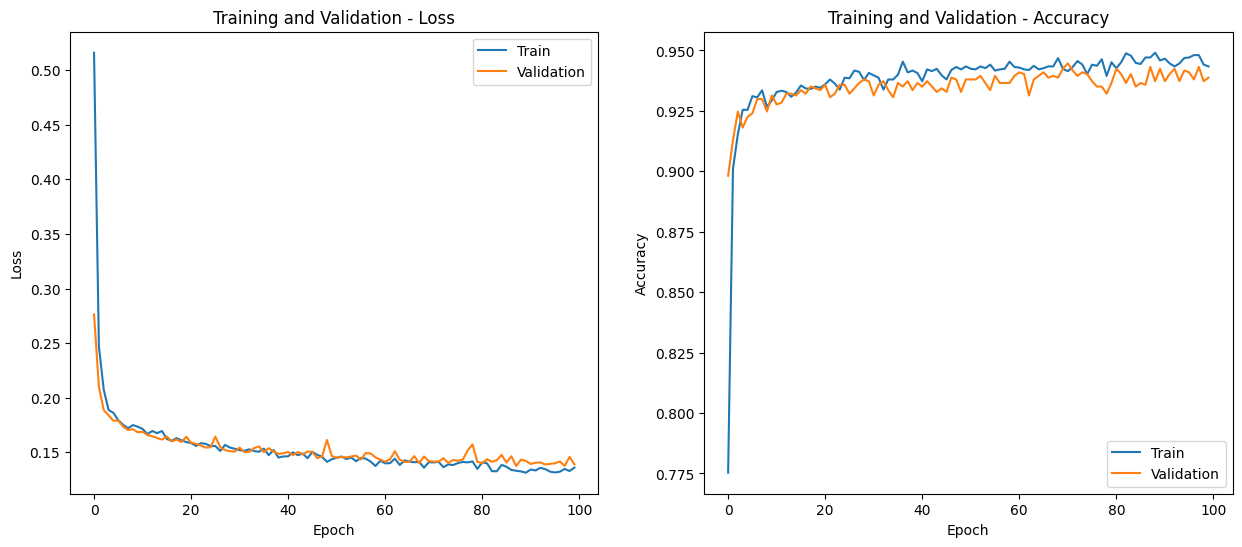

In [99]:
# Start the training
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=24, verbose=1)

# Save after training model
model.save('model_classification.h5')

# Plot training & validation loss values
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation - Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation - Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.show()

The model shows good learning with both training and validation loss curve decrease and stabalise eventually. This indicates no overfitting or underfitting.

However and interestingly, while testing for different dropout rate, high dropout rate could lead to training loss > validation loss by very small amount in most epochs (slightly underfitted). This could indication that the training dataset possiblily be more challenging than the validation set, which is unlikely given that the dataset was randomised. Another reason I believe is related to slightly over-regulated.

After tuning down on the dropout rate, both training and validation loss curve decrease smoothly over epochs, also a relatively low loss and high accuarcy and stability shown in the accuaracy plot for both training and validation set.

Given this results, we can evaluate the model on the test set.

\
Accuracy, Precision, Recall, and F1-Score:

•	Accuracy: The ratio of correctly predicted positive and negative observations to the total number of predictions. Precision = (TP + TN) / (TP + FP + TN + FN)

•	Precision: The ratio of correctly predicted positive observations to the total predicted positives. Precision = TP / (TP + FP)

•	Recall: The ratio of correctly predicted positive observations to all observations in the actual class. Recall = TP / (TP + FN)

•	F1-Score: The weighted average of Precision and Recall. F1 Score = 2 * (Precision * Recall) / (Precision + Recall)

Note: support = number of samples


43/43 [==============================] - 0s 2ms/step - loss: 0.1498 - accuracy: 0.9446


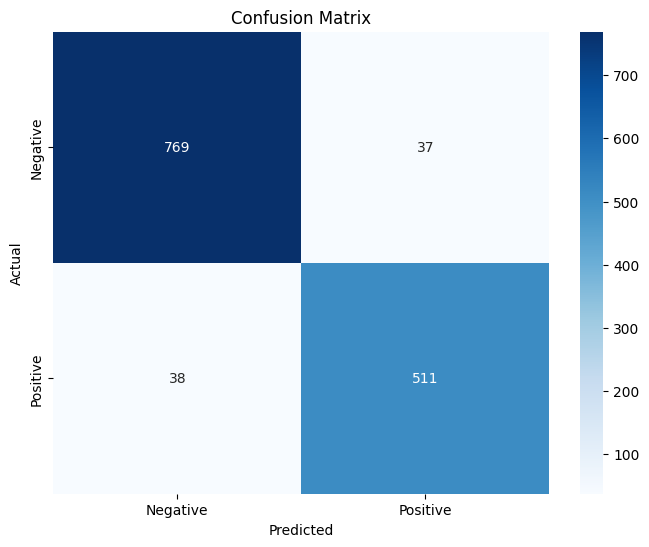


Test Sample Size: 1355
Accuracy:         94.46%
Precision:        93.25%
Recall:           93.08%
F1-score:         93.16%

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       806
           1       0.93      0.93      0.93       549

    accuracy                           0.94      1355
   macro avg       0.94      0.94      0.94      1355
weighted avg       0.94      0.94      0.94      1355



In [107]:
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

test_sample_size = y_test.shape[0]
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)

print(f"\nTest Sample Size: {test_sample_size}")
print(f"Accuracy:         {accuracy*100:.2f}%")
print(f"Precision:        {precision*100:.2f}%")
print(f"Recall:           {recall*100:.2f}%")
print(f"F1-score:         {f1*100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

# **Regression Model**

First thing to do is to fill the missing values for feature columns, I'm using KNN this time (tested with linear and KNN, and the the results are similar; linear maybe be slighly better but only by very little). Then feature selection, I use Mutual information regression as it captures the dependency between features and the target variable, alongside with correlation analysis.

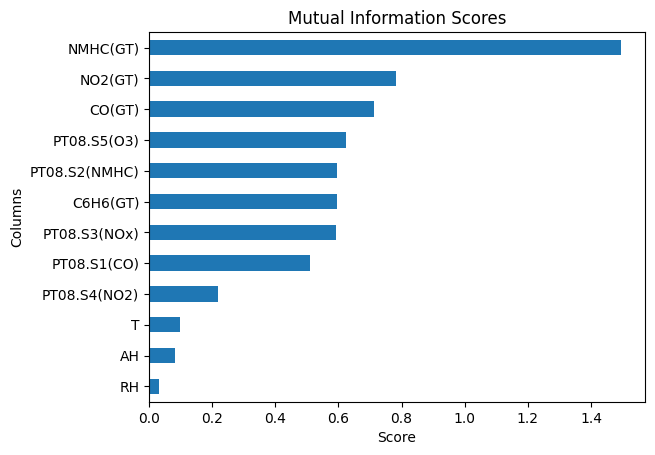

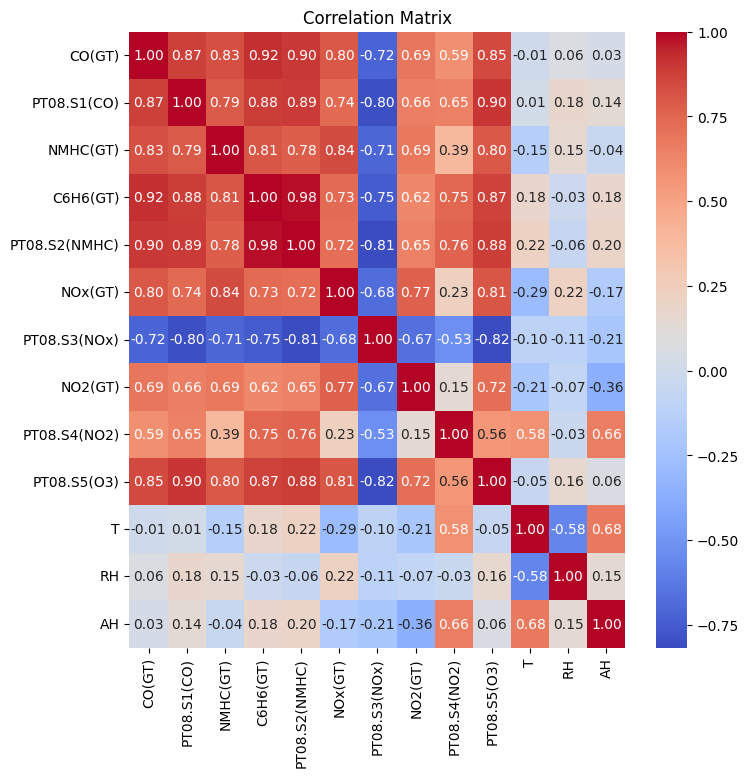

In [58]:
data = pd.read_excel(file_path)
data.replace(-200, np.nan, inplace=True)

# Remove rows with missing values in column NOx(GT)
data = data.dropna(subset=['NOx(GT)'])

# KNN imputation
knn_imputer = KNNImputer(n_neighbors=10)
# Perform KNN imputation on numerical data, excluding the 'Date' and 'Time' columns
data_knn  = pd.DataFrame(knn_imputer.fit_transform(data.iloc[:, 2:]), columns=data.columns[2:])

data_temp = data_knn.drop(columns=['NOx(GT)'])
y = data['NOx(GT)']
mi = mutual_info_regression(data_temp, y)

# Create a DataFrame to display the results
mi_df = pd.DataFrame(mi, index=data_temp.columns, columns=['Mutual Information']).sort_values(by='Mutual Information')

mi_df.plot(kind='barh', legend=False)
plt.title('Mutual Information Scores')
plt.ylabel('Columns')
plt.xlabel('Score')
plt.show()

print()

plt.figure(figsize=(8, 8))
corr_matrix = data_knn.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

The Mutual Information Score and Correlation Matrix indicate similar dependency results. Therefore, we can drop columns 'NOx(GT)', 'AH', 'RH'.


In [59]:
X = data_knn.drop(columns=['NOx(GT)', 'AH', 'RH'])

# Normalise data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
print(X_normalized)
X_normalized.shape

[[0.21186441 0.52388828 0.12098139 ... 0.51303957 0.45465407 0.33333333]
 [0.16101695 0.47409041 0.08883249 ... 0.453125   0.3263821  0.32688172]
 [0.1779661  0.55475928 0.06852792 ... 0.45121403 0.3705876  0.29677419]
 ...
 [0.08474576 0.20378537 0.16505922 ... 0.18244155 0.12903226 0.45322581]
 [0.10169492 0.20323411 0.19145516 ... 0.18660072 0.13880743 0.46935484]
 [0.07627119 0.17897832 0.13790186 ... 0.16164568 0.10220484 0.45376343]]


(6785, 10)

After experimenting with time-series dataset splitting and random splitting, I found time-series splitting tends to be easier to overfit than random split. In addition, models that were trained with random split has better performance on both randomised and non-randomised test set. One reason I think is because the model were "forced" to learn to predict under different sinarios disregarding the impact of sample ordering, hence were more generalised and robust while the non-randomised trained models only performs well on training set but not very well in the randomised and non-randomised test set (overfitting).

In addition, I also found the model has better performance without/with very small (< 0.3) dropout rate, models learnt to predict better on more extreme values whereas models with high dropout rate were regularise hence perform not as good when predicting extreme values (over-restricted).

\
The following code showcases the randomised training model and the performance of random test case:

In [60]:
# First split: training set (60) and temp set (40)
X_train, X_temp, y_train, y_temp = train_test_split(X_normalized, y, test_size=0.3, random_state=1)

# Second split: validation set (40/2) and test set (40/2)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f'Training Set Size:      {X_train.shape[0]}')
print(f'Validation Sample Size: {X_val.shape[0]}')
print(f'Testing Sample Size:    {X_test.shape[0]}')

Training Set Size:      4749
Validation Sample Size: 1018
Testing Sample Size:    1018


In [64]:
# Define the model architecture
def build_model(input_dim, n_neurons, dropout_rates):
    model = Sequential()
    model.add(Dense(n_neurons[0], input_dim=input_dim, activation='relu'))
    model.add(Dropout(dropout_rates[0]))
    model.add(Dense(n_neurons[1], activation='relu'))
    model.add(Dropout(dropout_rates[1]))
    model.add(Dense(1, activation='linear'))
    return model

input_dim = X_train.shape[1]
n_neurons = [16, 16]
dropout_rates = [0.03, 0.095]
model = build_model(input_dim, n_neurons, dropout_rates)
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.012), metrics=['mean_absolute_error'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 16)                176       
                                                                 
 dropout_16 (Dropout)        (None, 16)                0         
                                                                 
 dense_25 (Dense)            (None, 16)                272       
                                                                 
 dropout_17 (Dropout)        (None, 16)                0         
                                                                 
 dense_26 (Dense)            (None, 1)                 17        
                                                                 
Total params: 465 (1.82 KB)
Trainable params: 465 (1.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/100
198/198 [==============================] - 1s 3ms/step - loss: 41390.2578 - mean_absolute_error: 139.0719 - val_loss: 12374.9346 - val_mean_absolute_error: 73.2173
Epoch 2/100
198/198 [==============================] - 0s 2ms/step - loss: 10296.7900 - mean_absolute_error: 69.6419 - val_loss: 8427.0791 - val_mean_absolute_error: 62.4259
Epoch 3/100
198/198 [==============================] - 0s 2ms/step - loss: 9272.3457 - mean_absolute_error: 64.5215 - val_loss: 6756.7251 - val_mean_absolute_error: 53.5754
Epoch 4/100
198/198 [==============================] - 1s 4ms/step - loss: 8342.4307 - mean_absolute_error: 58.6527 - val_loss: 7087.6455 - val_mean_absolute_error: 52.6664
Epoch 5/100
198/198 [==============================] - 1s 4ms/step - loss: 7819.4678 - mean_absolute_error: 57.7338 - val_loss: 6152.1714 - val_mean_absolute_error: 50.0905
Epoch 6/100
198/198 [==============================] - 1s 4ms/step - loss: 7527.9673 - mean_absolute_error: 57.1004 - val_loss: 629

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


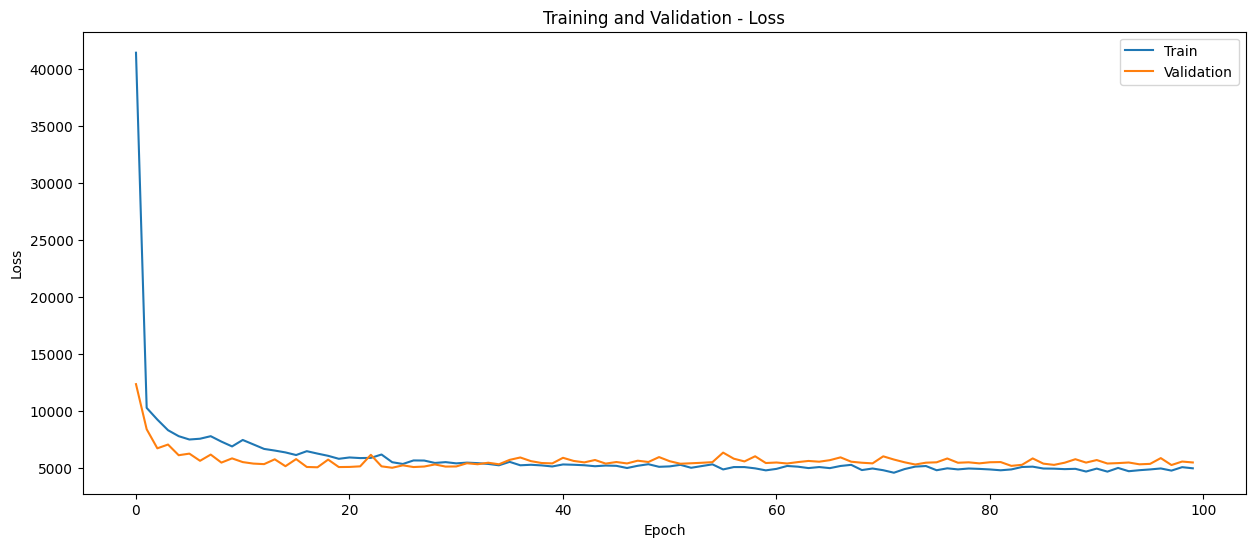

32/32 [==============================] - 0s 1ms/step


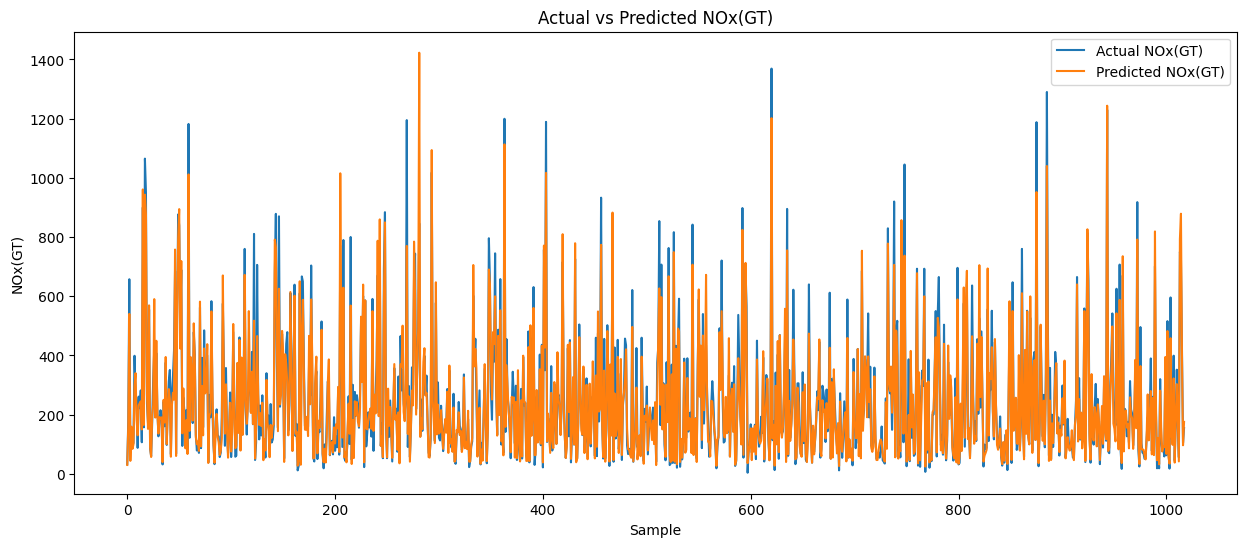

In [65]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=24, verbose=1)

# Save after training model
model.save('model_regression.h5')

# Plot training & validation loss values
plt.figure(figsize=(15, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation - Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# test model performance on test set
y_pred = model.predict(X_test)

# Plot training & validation accuracy values
plt.figure(figsize=(15, 6))
plt.plot(y_test.values, label='Actual NOx(GT)')
plt.plot(y_pred, label='Predicted NOx(GT)')
plt.xlabel('Sample')
plt.ylabel('NOx(GT)')
plt.title('Actual vs Predicted NOx(GT)')
plt.legend(['Actual NOx(GT)', 'Predicted NOx(GT)'], loc='upper right')
plt.show()

In [67]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Number of Samples: {len(y_test)}")
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')

Number of Samples: 1018
Root Mean Squared Error (RMSE): 61.4742
Mean Absolute Error (MAE): 37.9718


My original approach for filling missing data was to fill everything by using different filling methods, including the target column which I was not able to get a lower RMSE and MAE than 80/60 on the testing set.

However, after some twisting and experimentings, I realised the issue was not about choicing the right filling methods (although some are better than the others), it is more about which columns to fill. If we have a "big enough" target column (often it's not big enough because the more the better), we shouldn't fill in values for the target columns because we are only estimating these values which can be highly variated from the true value even we tried to minimised.

After realising this, I tried again to remove rows of sample with missing value in the target column, the result was a lot better.





---



---

\
Below code is used for loading new dataset and discussion.

1. Load dataset from drive

2. Data preprocessing and select features from the dataset for specific task

3. Use pre-trained classification model to test model accuracy and precision, and generate confusion matrix

4. Use pre-trained regression model to test model RMSE and MAE


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.impute import KNNImputer
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

%cd /content/drive/MyDrive/UNSW/COMP9414/ass1
file_path = '' # Enter filename
data = pd.read_excel(file_path)
data.describe()

In [ ]:
# Just to make sure the missing values == -200
print("Column Name      No. of Missing Values")
print('======================================')
missing = data[data.columns] == -200
missing.sum()

In [ ]:
# Data preprocessing for classification task
data = pd.read_excel(file_path)
# Replace -200 with NaN
data.replace(-200, np.nan, inplace=True)
data = data.dropna(subset=['CO(GT)'])

# Normalise data
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data.iloc[:, 2:])

# Interpolate data with kNN method
knn_imputer = KNNImputer(n_neighbors=10)
# Perform KNN imputation on numerical data, excluding the 'Date' and 'Time' columns
data_knn  = pd.DataFrame(knn_imputer.fit_transform(data_normalized), columns=data.columns[2:])
data_knn.describe()

# Classification Task

In [ ]:
# In order to do feature selection, we need to find Y
threshold = data_knn['CO(GT)'].mean()
data_knn['CO(GT)_threshold'] = (data_knn['CO(GT)'] > threshold).astype(int)

# Feature selection
X = data_knn.drop(columns=['CO(GT)', 'CO(GT)_threshold', 'T', 'RH'])
y = data_knn['CO(GT)_threshold']

# Normalization using MinMaxScalar
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Load model
model = load_model('model_classification.h5')
# Model Architecture:
# Learning Rate: 0.0015
# Optimazer: Adam
# Input Layer: input dimension (10)
# First Hidden Layer: 16 neurons (Activation: Relu)
# Dropout Layer: 12% dropout rate
# Second Hidden Layer: 16 neurons (Activation: Relu)
# Dropout Layer: 13% dropout rate
# Output Layer: 1 neuron (Activation: Sigmoid)
# Total params: 465

# Evaluate the model on the genralised set
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

test_sample_size = y_test.shape[0]
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)

print(f"\nTest Sample Size: {test_sample_size}")
print(f"Accuracy:         {accuracy*100:.2f}%")
print(f"Precision:        {precision*100:.2f}%")
print(f"Recall:           {recall*100:.2f}%")
print(f"F1-score:         {f1*100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Regression Task

In [ ]:
# Data preprocessing for regression task
data = pd.read_excel(file_path)
# Replace -200 with NaN
data.replace(-200, np.nan, inplace=True)

# Interpolate data with kNN method
data = data.dropna(subset=['NOx(GT)'])

knn_imputer = KNNImputer(n_neighbors=10)
# Perform KNN imputation on numerical data, excluding the 'Date' and 'Time' columns
data_knn  = pd.DataFrame(knn_imputer.fit_transform(data.iloc[:, 2:]), columns=data.columns[2:])

# Feature selection
X = data_knn.drop(columns=['NOx(GT)', 'AH', 'RH'])
y = data_knn['NOx(GT)']

# Normalization using MinMaxScalar
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
X_normalized_df = pd.DataFrame(X_normalized, columns=X.columns)
X_normalized_df.describe()

In [ ]:
# Load model
model = load_model('model_regression.h5')
# Model Architecture:
# Learning Rate:0.012
# Optimazer: Adam
# Input Layer: input dimension (10)
# First Hidden Layer: 16 neurons (Activation: Relu)
# Dropout Layer: 3% dropout rate
# Second Hidden Layer: 16 neurons (Activation: Relu)
# Dropout Layer: 9.5% dropout rate
# Output Layer: 1 neuron (Activation: Linear)
# Total params: 465

# Evaluate the model on the genralised set
y_pred = model.predict(X_normalized)

mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)

print(f"Number of Samples: {len(y)}")
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')